In [ ]:
!pip install pyts
!pip install --upgrade pyts

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix,f1_score
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import sys
from scipy import stats
from scipy.fft import fft, dct
import pywt
from sklearn.preprocessing import LabelEncoder
np.set_printoptions(threshold=sys.maxsize)
from matplotlib.backends.backend_pdf import PdfPages
import os
from pyts.approximation import PiecewiseAggregateApproximation as PAA
from scipy.fftpack import idct

def generate_random_vectors(n, r):
    random_vectors = np.random.normal(0, 1, size=(r, n))
    return random_vectors

def MINE(data,R,R_inv):

  prod = np.matmul(data,R)
  bitmap = np.where(prod < 0, 0, 1)
  recon = np.matmul(bitmap,R_inv)
  return recon

def plot_confidence_interval(scores,method,stride,compression,type):
    # compute mean silhouette score and confidence interval
    mean_score = np.mean(scores)
    ci = stats.t.interval(0.95, len(scores)-1, loc=mean_score, scale=stats.sem(scores))

    # 2D array with the lower and upper bounds of the confidence interval
    yerr = np.array([[mean_score-ci[0]], [ci[1]-mean_score]])

    # create the figure and axis objects
    fig, ax = plt.subplots()

    # plot the data with error bars
    ax.plot(scores, marker='o')
    ax.errorbar(x=range(len(scores)), y=scores, yerr=yerr, fmt='none', ecolor='r')

    # set the axis labels and title
    ax.set_xlabel('Subset of features')

    if type == 'SC' :
     ax.set_ylabel('ACCURACY score')
     if method == 'RAW':
      ax.set_title(f'ACCURACY scores with 95% confidence interval\n M={method} , W= {stride} : [{ci[0]:.5f}, {ci[1]:.5f}]')
     else:
      ax.set_title(f'ACCURACY scores with 95% confidence interval\n M={method} , W= {stride}, C= {compression} : [{ci[0]:.5f}, {ci[1]:.5f}]')


    if type == 'RMSE' :
     ax.set_ylabel('F1 score')
     if method == 'RAW':
      ax.set_title(f'F1 scores with 95% confidence interval\n M={method} , W= {stride} : [{ci[0]:.5f}, {ci[1]:.5f}]')
     else:
      ax.set_title(f'F1 scores with 95% confidence interval\n M={method} , W= {stride}, C= {compression} : [{ci[0]:.5f}, {ci[1]:.5f}]')
    # return the figure object
    return fig

def plot_score_confidence_interval(data,window_size,compression):
    fig, axs = plt.subplots(1, 5, figsize=(20, 4), sharey=True)  # Adjust the figure size as needed

    colors = ['b', 'g', 'r', 'c', 'm']  # Colors for each method

    #y_axis_limits = (-5, 5)  # axis limits

    for i, (scores, method) in enumerate(data):
        ax = axs[i]
        n = len(scores)
        x = np.arange(n) + 1
        y = np.array(scores)

        # Identify and count outliers based on the limits
        outliers = np.where((y < -5) | (y > 5))[0]
        num_outliers = len(outliers)

        # Exclude outliers from the data
        filtered_scores = np.delete(y, outliers)
        filtered_x = np.delete(x, outliers)

        mean = np.mean(filtered_scores)
        # Calculate the confidence interval
        ci = stats.t.interval(0.95, len(filtered_scores), loc=mean, scale=stats.sem(filtered_scores))
        # Plot the non-outlier data points and mean
        ax.plot(filtered_x, filtered_scores, 'o', markersize=4, color=colors[i])
        ax.plot(x, [mean] * n, '--', color=colors[i])

        fig.suptitle(f'ACCURACY scores with 95% confidence interval // W= {window_size}, C= {compression} ')

        ax.set_xlabel('Window')
        ax.set_ylabel('Score')
        ax.set_title(f'{method} : [{ci[0]:.5f}, {ci[1]:.5f}] ')
        ax.grid(True)

        # Set the y-axis limits
        #ax.set_ylim(y_axis_limits)

        # Add the number of outliers as text in the top right corner
        ax.text(0.85, 0.9, f'Outliers: {num_outliers}', transform=ax.transAxes, fontsize=10, color='red', ha='right')

    return fig

def plot_F1_confidence_interval(data,window_size,compression):
    fig, axs = plt.subplots(1, 5, figsize=(20, 4), sharey=True)  # Adjust the figure size as needed

    colors = ['b', 'g', 'r', 'c', 'm']  # Colors for each method

   # y_axis_limits = (-5, 5) # Outlier limits

    for i, (scores, method) in enumerate(data):
        ax = axs[i]
        n = len(scores)
        x = np.arange(n) + 1
        y = np.array(scores)
        # Identify and count outliers based on the limits
        outliers = np.where((y < -5) | (y > 5))[0]
        num_outliers = len(outliers)

        # Exclude outliers from the data
        filtered_scores = np.delete(y, outliers)
        filtered_x = np.delete(x, outliers)

        mean = np.mean(filtered_scores)
        # Calculate the confidence interval
        ci = stats.t.interval(0.95, len(filtered_scores), loc=mean, scale=stats.sem(filtered_scores))

        # Plot the non-outlier data points and mean
        ax.plot(filtered_x, filtered_scores, 'o', markersize=4, color=colors[i])
        ax.plot(x, [mean] * n, '--', color=colors[i])

        fig.suptitle(f'F1 scores with 95% confidence interval // W= {window_size}, C= {compression} ')

        ax.set_xlabel('Window')
        ax.set_ylabel('Score')
        ax.set_title(f'{method} : [{ci[0]:.5f}, {ci[1]:.5f}]')
        ax.grid(True)

        # Set the y-axis limits to the predefined range
       # ax.set_ylim(y_axis_limits)

        # Add the number of outliers as text in the top right corner
        ax.text(0.85, 0.9, f'Outliers: {num_outliers}', transform=ax.transAxes, fontsize=10, color='red', ha='right')

    return fig

# Load data
df = pd.read_csv('/content/drive/MyDrive/pump_sensor2.txt', delimiter=',')

# BROKEN,NORMAL,RECOVERING -> 0,0.5,1
le = LabelEncoder()
df.iloc[:, -1] = le.fit_transform(df.iloc[:, -1])
max_label = df.iloc[:, -1].max()
df.iloc[:, -1] = df.iloc[:, -1] / max_label * 1.0
# Discard the first row + first two columns
df = df.iloc[:, 2:]
data = df.to_numpy(dtype='float')
# Split  features (X) and target (y)
X = data[:, :-1]
#print(X)
y = data[:, -1]
#print(y[0])
# Fill Nan values based on the mean of each sensor
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X = imputer.fit_transform(X)
# Select 1000 0.5 kai 1 labels
label_05_indices = np.where(y == 0.5)[0]
label_1_indices = np.where(y == 1)[0]
label_05_indices = np.random.choice(label_05_indices, size=1000, replace=False)
label_1_indices = np.random.choice(label_1_indices, size=1000, replace=False)
# Concatenate + shuffle
indices = np.concatenate((label_05_indices, label_1_indices))
np.random.seed(123)   #Gia idio dataset shuffle se ola ta algorithms
np.random.shuffle(indices)
X= X[indices]
y= y[indices]
y[y == 0.5] = 0
# unique_labels, label_counts = np.unique(y, return_counts=True)
# for i in range(len(unique_labels)):
#    print(f"Label {unique_labels[i]}: {label_counts[i]}")
# X = imputer.fit_transform(X)



# window size, etc.
window_sizes = [16, 32, 64, 128]
compressions = [4, 8, 16]
methods = ['DFT', 'DCT', 'DWT', 'PAA','MINE']

#file for storing
folder_name = f"SVM new PUMP Measurements"
if not os.path.exists(folder_name):
   os.makedirs(folder_name)

raw_folder_name = f"RAW DATA"
if not os.path.exists(os.path.join(folder_name,raw_folder_name)):
   os.makedirs(os.path.join(folder_name,raw_folder_name))
pdf_file = os.path.join(folder_name,raw_folder_name, 'plots.pdf')

with PdfPages(pdf_file, 'a') as pdf:
  for window_size in window_sizes:

     # lists to store metrics for each window
     f1_list = []
     accuracy_list = []
     num =int( window_size+window_size/4)

     # Iterate over the windows
     for i in range(0, len(X)-window_size*2+1, window_size):

          # Split the data into training and testing sets
          X_train = X[i:i+window_size]
          X_test = X[i+window_size:i+num]
          y_train = y[i:i+window_size]
          y_test = y[i+window_size:i+num]
          #print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

          # Data scaling
          sc = MinMaxScaler()
          X_train_scaled = sc.fit_transform(X_train)
          X_test_scaled = sc.transform(X_test)

          #print(X_train_scaled[0], X_test_scaled[0], y_train_scaled[0], y_test_scaled[0])

          # model
          SVM_model = SVC(kernel='rbf', gamma=1, C=10)
          SVM_model.fit(X_train_scaled, y_train)

          # predictions
          y_pred_scaled = SVM_model.predict(X_test_scaled)

          # performance
          accuracy = accuracy_score(y_test, y_pred_scaled)
          accuracy_list.append(accuracy)
          f1 = f1_score(y_test, y_pred_scaled)
          f1_list.append(f1)

     #store plots
     methd = 'RAW'
     comprsn = 0
     fig = plot_confidence_interval(accuracy_list,methd,window_size ,comprsn,'SC') #plot function call
     pdf.savefig(fig)
     plt.close(fig)

     fig2 = plot_confidence_interval(f1_list,methd,window_size ,comprsn,'RMSE') #plot function call
     pdf.savefig(fig2)
     plt.close(fig2)

     # create a file name based on the method, subset index, stride, and compression
     avg_accuracy = np.mean(accuracy_list)
     file_name = f"Window size({window_size}) - accuracy-scores.txt"
     with open(os.path.join(folder_name,raw_folder_name, file_name), 'w+') as f:
              f.write(f"Average accuracy Score: {avg_accuracy}\n")
              content = str(accuracy_list)
              f.write(content)
              f.close()

     avg_f1 = np.mean(f1_list)
     file_name = f"Window size({window_size}) - f1 scores).txt"
     with open(os.path.join(folder_name,raw_folder_name, file_name), 'w+') as f:
              f.write(f"Average f1 Score: {avg_f1}\n")
              content = str(f1_list)
              f.write(content)
              f.close()

for window_size in window_sizes:

    #file for storing
    stride_folder_name = f"stride({window_size})"
    if not os.path.exists(os.path.join(folder_name,stride_folder_name)):
        os.makedirs(os.path.join(folder_name,stride_folder_name))

    for compression in compressions:

        #vector and inverse vector arrays for our algorithm
        n = 64*int(window_size/compression)  # Dimension of each random vector
        r = 51  # Number of random vectors to generate/rows
        R = generate_random_vectors(n, r)
        R_inv= np.linalg.pinv(R)

        #files for storing measurements
        compression_folder_name = f"compression({compression})"
        if not os.path.exists(os.path.join(folder_name,stride_folder_name, compression_folder_name)):
            os.makedirs(os.path.join(folder_name,stride_folder_name, compression_folder_name))

        #files for storing plots
        plots_dir = os.path.join(folder_name,stride_folder_name, compression_folder_name, 'plots')
        os.makedirs(plots_dir, exist_ok=True)
        pdf_file = os.path.join(plots_dir, 'plots.pdf')

        with PdfPages(pdf_file, 'a') as pdf:
            results1 = []
            results2 = []
            for method in methods:

                slices = window_size // compression

                # lists to store metrics for each window
                f1_list = []
                accuracy_list = []
                num =int( window_size+window_size/4)

                # Iterate over the windows
                for i in range(0, len(X)-window_size*2+1, window_size):

                   # Split the data into training and testing sets
                   X_train = X[i:i+window_size]
                   X_test = X[i+window_size:i+num]
                   y_train = y[i:i+window_size]
                   y_test = y[i+window_size:i+num]
                   #print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

                   # Data scaling
                   sc = MinMaxScaler()
                   X_train_scaled = sc.fit_transform(X_train)
                   X_test_scaled = sc.transform(X_test)

                   #vector and inverse vector arrays for our algorithm
                  #  n = 64*int(window_size/compression)  # Dimension of each random vector
                  #  r = 51  # Number of random vectors to generate/rows
                  #  R = generate_random_vectors(n, r)
                  #  R_inv= np.linalg.pinv(R)

                   if method == 'DFT':

                       #array to store the restored data
                       compressed_X_train_scaled = np.zeros_like(X_train_scaled)

                       for i in range(window_size):
                          # Compute abs DFT of each row
                          dft_X_train_scaled  =  np.fft.fft(X_train_scaled[i])
                          # Sort the DFT coefficients along each row by their magnitude
                          sorted_indices = np.argsort(-np.abs(dft_X_train_scaled))[:slices]
                          sorted_dft_X_train_scaled = dft_X_train_scaled[sorted_indices]
                          # Keep  top  coeff
                          top__dft_X_train_scaled = sorted_dft_X_train_scaled[:slices]
                          #reconstruct the compressed dataset
                          compressed_X_train_scaled[i] = np.fft.ifft(top__dft_X_train_scaled,51).real

                       #array to store the restored data
                       compressed_X_test_scaled = np.zeros_like(X_test_scaled)

                       for i in range(int(window_size/4)):
                          # Compute abs DFT of each row
                          dft_X_test_scaled =  np.fft.fft(X_test_scaled[i])
                          # Sort the DFT coefficients along each row by their magnitude
                          sorted_indices = np.argsort(np.abs(dft_X_test_scaled))[::-1][:slices]
                          sorted_dft_X_test_scaled = dft_X_test_scaled[sorted_indices]
                          # Keep  top  coeff
                          top__dft_X_test_scaled = sorted_dft_X_test_scaled[:slices]
                          #reconstruct the compressed dataset
                          compressed_X_test_scaled[i] = np.fft.ifft(top__dft_X_test_scaled,51).real

                   elif method == 'DCT':

                       #array to store the restored data
                       compressed_X_train_scaled = np.zeros_like(X_train_scaled)

                       for i in range(window_size):
                          # Compute abs DCT of each row
                          dct_X_train_scaled  =  dct(X_train_scaled[i])
                          # Sort the DCT coefficients along each row by their magnitude
                          sorted_indices = np.argsort(-np.abs(dct_X_train_scaled))[:slices]
                          sorted_dct_X_train_scaled = dct_X_train_scaled[sorted_indices]
                          # Keep  top  coeff
                          top__dct_X_train_scaled = sorted_dct_X_train_scaled[:slices]
                          #reconstruct the compressed dataset
                          compressed_X_train_scaled[i] = idct(top__dct_X_train_scaled ,type = 2, n = 51).real

                       #array to store the restored data
                       compressed_X_test_scaled = np.zeros_like(X_test_scaled)

                       for i in range(int(window_size/4)):
                          # Compute abs DCT of each row
                          dct_X_test_scaled =  dct(X_test_scaled[i])
                          # Sort the DCT coefficients along each row by their magnitude
                          sorted_indices = np.argsort(-np.abs(dct_X_test_scaled))[:slices]
                          sorted_dct_X_test_scaled = dct_X_test_scaled[sorted_indices]
                          # Keep  top  coeff
                          top__dct_X_test_scaled = sorted_dct_X_test_scaled[:slices]
                          #reconstruct the compressed dataset
                          compressed_X_test_scaled[i] = idct(top__dct_X_test_scaled ,type = 2 , n = 51).real

                   elif method == 'DWT':

                      #array to store the restored data
                      compressed_X_train_scaled = np.zeros_like(X_train_scaled)
                      compressed_X_train_scaled = np.pad(compressed_X_train_scaled, ((0, 0), (0, 1)), 'constant', constant_values=0)
                      for i in range(window_size):
                          # Apply DWT to each row using 'db1' wavelet
                          cA, cD = pywt.dwt(X_train_scaled[i], 'db1')
                          # Sort
                          sorted_cD_subset_data = np.zeros_like(cD) #initialize storage array
                          sorted_indices = np.argsort(-np.abs(cD))[:slices]
                          sorted_cD_subset_data[sorted_indices] = cD[sorted_indices]
                          # Perform inverse DWT to restore the row
                          compressed_X_train_scaled[i] = pywt.idwt(cA, sorted_cD_subset_data, 'db1')

                      #array to store the restored data
                      compressed_X_test_scaled = np.zeros_like(X_test_scaled)
                      compressed_X_test_scaled = np.pad(compressed_X_test_scaled, ((0, 0), (0, 1)), 'constant', constant_values=0)
                      for i in range(int(window_size/4)):
                          # Apply DWT to each row using 'db1' wavelet
                          cA, cD = pywt.dwt(X_test_scaled[i], 'db1')
                          # Sort
                          sorted_cD_subset_data = np.zeros_like(cD) #initialize storage array
                          sorted_indices = np.argsort(-np.abs(cD))[:slices]
                          sorted_cD_subset_data[sorted_indices] = cD[sorted_indices]
                          # Perform inverse DWT to restore the row
                          compressed_X_test_scaled[i] = pywt.idwt(cA, sorted_cD_subset_data, 'db1')


                   elif method == 'PAA':
                      # Apply PAA along the rows of the array
                      paa = PAA(window_size = compression)
                      compressed_X_train_scaled = paa.fit_transform(X_train_scaled)
                      compressed_X_test_scaled = paa.fit_transform(X_test_scaled)

                   elif method == 'MINE':

                      #array to store the restored data
                      compressed_X_train_scaled = np.zeros_like(X_train_scaled)

                      for i in range(window_size):
                        row = X_train_scaled[i]
                        # Apply my algorithm along the rows of the array
                        compressed_X_train_scaled[i] = MINE(row,R,R_inv)

                      #array to store the restored data
                      compressed_X_test_scaled = np.zeros_like(X_test_scaled)
                      for i in range(int(window_size/4)):
                        row = X_test_scaled[i]
                        # Apply my algorithm along the rows of the array
                        compressed_X_test_scaled[i] = MINE(row,R,R_inv)



                   # model
                   SVM_model = SVC(kernel='rbf', gamma=1, C=10)
                   SVM_model.fit(compressed_X_train_scaled, y_train)

                   # predictions
                   y_pred_scaled = SVM_model.predict(compressed_X_test_scaled)

                   # performance (mean squared error, mean absolute error, and R-squared score)
                   accuracy = accuracy_score(y_test, y_pred_scaled)
                   accuracy_list.append(accuracy)
                   f1 = f1_score(y_test, y_pred_scaled)
                   f1_list.append(f1)

                results1.append((accuracy_list, method))
                results2.append((f1_list, method))

                # create a file name based on the method, subset index, stride, and compression
                avg_accuracy = np.mean(accuracy_list)
                file_name = f"{method}_window size({window_size})_compression({compression} - ACCURACY SCORES).txt"
                with open(os.path.join(folder_name,stride_folder_name, compression_folder_name, file_name), 'w+') as f:
                   f.write(f"Average accuracy Score: {avg_accuracy}\n")
                   content = str(accuracy_list)
                   f.write(content)
                   f.close()

                avg_f1 = np.mean(f1_list)
                file_name = f"{method}_window size({window_size})_compression({compression} - f1 SCORES).txt"
                with open(os.path.join(folder_name,stride_folder_name, compression_folder_name, file_name), 'w+') as f:
                   f.write(f"Average f1 Score: {avg_f1}\n")
                   content = str(f1_list)
                   f.write(content)
                   f.close()
            #store plots
            fig = plot_score_confidence_interval(results1,window_size,compression) #plot function call
            pdf.savefig(fig)
            plt.close(fig)
            fig = plot_F1_confidence_interval(results2,window_size,compression) #plot function call
            pdf.savefig(fig)
            plt.close(fig)



<ipython-input-3-d7a9b3c16fb5>:157: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, -1] = le.fit_transform(df.iloc[:, -1])
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/

Accuracy:  0.9997821350762527
Confusion Matrix: 
[[    0     2     0]
 [    1 51420     3]
 [    1     5  3648]]


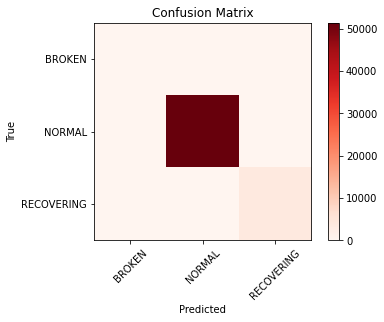

In [ ]:
#@title Whole file
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import sys

np.set_printoptions(threshold=sys.maxsize)

# Load data
df = pd.read_csv('/content/drive/MyDrive/pump_sensor2.txt', delimiter=',')

# encode BROKEN,NORMAL,RECOVERING -> 0,1,2
le = LabelEncoder()
df.iloc[:, -1] = le.fit_transform(df.iloc[:, -1])

# Discard first row + first two columns
df = df.iloc[:, 2:]

data = df.to_numpy(dtype='float')

# Split features X and target y
X = data[:, :-1]
y = data[:, -1]
#print("Class counts: ", np.unique(y, return_counts=True))

# Fill Nan values based on the mean of each sensor
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X = imputer.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)
#print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# data scaling
sc = MinMaxScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

# model
SVM_model = SVC(kernel='rbf', gamma=1, C=10)
SVM_model.fit(X_train_scaled, y_train)

# predictions
y_pred = SVM_model.predict(X_test_scaled)

# Performance (accuracy and confusion matrix)
accuracy = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Confusion Matrix: ")
print(conf_mat)

# Plot the confusion matrix
labels = ['BROKEN', 'NORMAL', 'RECOVERING']
plt.imshow(conf_mat, cmap=plt.cm.Reds)
plt.title("Confusion Matrix")
plt.xticks([0,1,2], labels, rotation=45)
plt.yticks([0,1,2], labels)
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# Load data
df = pd.read_csv('/content/drive/MyDrive/pump_sensor2.txt', delimiter=',')

# encode BROKEN,NORMAL,RECOVERING -> 0,1,2
le = LabelEncoder()
df.iloc[:, -1] = le.fit_transform(df.iloc[:, -1])

# Discard first row + first two columns
df = df.iloc[:, 2:]

data = df.to_numpy(dtype='float')

# Split features X and target y
X = data[:, :-1]
y = data[:, -1]

# Fill Nan values based on the mean of each sensor
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X = imputer.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

# data scaling
sc = MinMaxScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

# Create a pipeline with SVM classifier and scaler
pipe = Pipeline([('scaler', MinMaxScaler()), ('svm', SVC(kernel='rbf'))])

# Define parameter grid for grid search
param_grid = {'svm__C': [0.1, 1, 10], 'svm__gamma': [0.1, 1, 10]}

# Perform grid search using 5-fold cross validation
grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Print the best hyperparameters and their corresponding score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)


Best hyperparameters:  {'svm__C': 10, 'svm__gamma': 1}
Best score:  0.9998123940934398
